In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.color import rgb2gray
from PIL import Image
import numpy as np
import cv2
import copy 

[46, 70, 273, 303] yes
[ 46 382 303 382] here
[ 46 382  46 144] here
[303 382 303 144] here
[ 70 302 273 302] here
[ 70 350 273 350] here
[303 382 303 144] here
[ 70 350  70 302] here
[273 350 273 302] here
[[  0   0 257   0]
 [ 24  80 227  80]
 [ 24  32 227  32]]
[[  0   0   0 238]
 [257   0 257 238]
 [257   0 257 238]
 [ 24  32  24  80]
 [227  32 227  80]]
[]


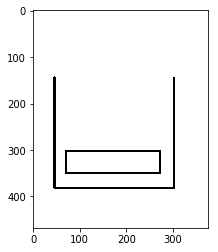

In [2]:
def same(arr1,arr2):
    r=10
    if abs(arr1[0]-arr2[0])<r and abs(arr1[1]-arr2[1])<r and abs(arr1[2]-arr2[2])<r and abs(arr1[3]-arr2[3])<r:
        return True
    else :
        return False
    
def samep(n1,n2):
    r=10
    if abs(n1-n2)<r:
        return True
    else:
        return False
    
    
def im_in(n, array):
    r=20
    for i in array:
        if abs(n-i)<r:
            return True
        
    return False
    
test = cv2.imread("proposal_t.png")

white=cv2.imread('white12.png')
gray = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 200)
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 50, minLineLength=0, maxLineGap=0)









new_lines=[]




for i in range(len(lines)):
    flag=0
    if (i!=0):
        for j in range(i):
                if same(lines[i][0],lines[j][0]):
                    flag=1
                    continue
    if(flag==0):
        new_lines.append(lines[i][0])

        
xs=[]
ys=[]

for i in new_lines:
    xs.append(i[0])
    xs.append(i[2])
    ys.append(i[1])
    ys.append(i[3])
    
    
sorted_x=sorted(xs)
sorted_y=sorted(ys)

special_x=[]
special_y=[]


for i in sorted_x:
    if not(im_in(i, special_x)):
        special_x.append(i)
    
for i in sorted_y:
    if not(im_in(i, special_y)):
        special_y.append(i)

print(special_x,'yes')


r=20

for i in range(len(new_lines)):
    for j in range(len(special_x)):
        if(abs(new_lines[i][0]-special_x[j])<r):
            new_lines[i][0]=special_x[j]
            break
            
    for j in range(len(special_x)):
        if(abs(new_lines[i][2]-special_x[j])<r):
            new_lines[i][2]=special_x[j]
            break
    for j in range(len(special_y)):
        if(abs(new_lines[i][1]-special_y[j])<r):
            new_lines[i][1]=special_y[j]
            break
            
    for j in range(len(special_y)):
        if(abs(new_lines[i][3]-special_y[j])<r):
            new_lines[i][3]=special_y[j]
            break        
                
    
for i in range(len(new_lines)):   
    x1, y1, x2, y2 = new_lines[i]
    cv2.line(white, (x1, y1), (x2, y2), (0, 0, 0), 3)
#x1, y1, x2, y2 = new_lines[8]
#cv2.line(white, (x1, y1), (x2, y2), (255, 0, 0), 3)
for i in new_lines:
    print(i,'here')
    
    
plt.imshow(white)




#FOR FARAG's HAPPINESS
minx=min(special_x)
maxy=max(special_y)
for i in range(len(new_lines)):
    new_lines[i][0]-=minx
    new_lines[i][2]-=minx
    
    new_lines[i][1]=maxy-new_lines[i][1]
    new_lines[i][3]=maxy-new_lines[i][3]

    
horizontal=[]
vertical=[]
general_line=[]

for i in new_lines:
    if i[0]==i[2]:
        vertical.append(i)
    elif i[1]==i[3]:
        horizontal.append(i)
    else:
        general_line.append(i)

horizontal = np.array(horizontal)
vertical = np.array(vertical)

print(horizontal)
print(vertical)
print(general_line)
# Show result


plt.imshow(white)

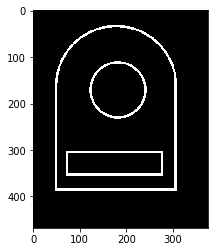

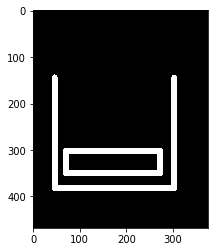

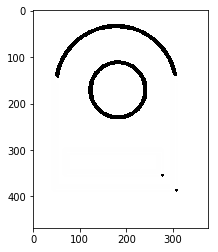

In [3]:
test=cv2.bitwise_not(test)
white2=cv2.bitwise_not(white)

plt.imshow(test)
plt.show()


white2 = cv2.dilate(white2,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9)),iterations = 1)
plt.imshow(white2)
plt.show()

output=test-white2

output = cv2.dilate(output,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)),iterations = 1)

output=cv2.bitwise_not(output)


plt.imshow(output)

In [4]:
def det_circles(img):
    
    img = cv2.medianBlur(img,5)
    circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,
                1,100,param1=50, param2=30, minRadius=0,maxRadius=0)
    circles = np.uint16(np.around(circles))
      
    return circles



    

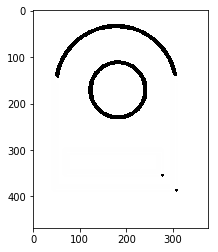

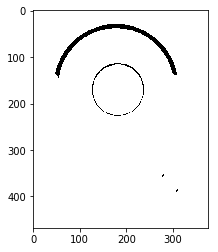

[array([[[182, 170,  63]]], dtype=uint16), array([[[178, 162, 133]]], dtype=uint16)]
63
133


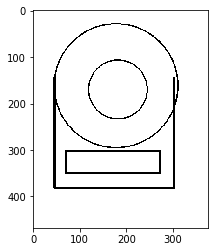

In [5]:
list_circles=[]

#output=cv2.imread('circles1.png')

plt.imshow(output)
plt.show()

gray = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)


circles=det_circles(gray)
list_circles.append(circles)
#white=cv2.imread('white12.png')

for i in circles[0,:4]:
    cv2.circle(white,(i[0],i[1]),i[2],(0,0,0),2)

test=cv2.bitwise_not(output)
white2=cv2.bitwise_not(white)
white2 = cv2.dilate(white2,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)),iterations = 1)
output=test-white2
output=cv2.bitwise_not(output)


output = cv2.cvtColor(output, cv2.COLOR_BGR2GRAY)
ret,output = cv2.threshold(output,100,255,cv2.THRESH_BINARY)

#close small circle::
output=cv2.bitwise_not(output)


kernal=cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
output = cv2.morphologyEx(output,cv2.MORPH_CLOSE,kernal,iterations = 5)
output=cv2.bitwise_not(output)


plt.imshow(output, cmap='gray')
plt.show()

circles2=det_circles(output)
list_circles.append(circles2)






print(list_circles)
for j in range(len(list_circles)):
    
    for i in list_circles[j][0,:4]:
        # #Getting The Centre
        # x = i[0]
        # y = i[1]
        #
        # #Getting The Radius
        # r = i[2]
        #draw the outer circle
        cv2.circle(white,(i[0],i[1]),i[2],(0,0,0),2)
        #draw the center of the circle
        #cv2.circle(white,(i[0],i[1]),2,(0,0,255),3)
        print (i[2])

        
        
for j in range(len(list_circles)):
    
    for i in range(len(list_circles[j][0,:4])):
        list_circles[j][0,:4][i][0]-=minx
        list_circles[j][0,:4][i][1]=maxy-list_circles[j][0,:4][i][1]




plt.imshow(white)






In [6]:
from dxfwrite import DXFEngine as dxf
from dxfwrite.dimlines import dimstyles, LinearDimension ,RadialDimension
import math
import numpy as np

Red=1
Yellow=2
Green=3
Labny=4
Blue=5
Foshia=6
White=7

class shapes:
    # Number of colors #

    drawing = ''

    def __init__(self,fileName):
        self.drawing = dxf.drawing(fileName + '.dxf')



    def text(self,text,x,y,color = Foshia):
        text = dxf.text(text, (x, y), height=0.3, rotation=0)
        text['layer'] = 'TEXT'
        text['color'] = color
        self.drawing.add(text)
        self.drawing.save()

    def line_with_NO_dims(self,x1, y1, x2, y2,color = White):
        line = dxf.line((x1, y1), (x2, y2))
        line['color'] = color
        self.drawing.add(line)
        self.drawing.save()

    def Horizontal_line_with_under_dims(self,x1, y1, x2, y2,color = White):
        line = dxf.line((x1, y1), (x2, y2))
        line['color'] = color
        self.drawing.add(line)

        dimstyles.setup(self.drawing)

        points = [(x1, y1 + 0.3), (x2, y1 + 0.3)]  # mn hna bt7dd x bta3 al point   # al y = height of blue line

        dimstyles.new("arrow", tick="DIMTICK_ARROW",height=0.3, tick2x=True, dimlineext=0.)

        # The angle control the slope of line
        Theta = math.atan((y1 - y2) / (x1 - x2))
        Theta = math.degrees(Theta)
        self.drawing.add(
            LinearDimension((10, y1 - 1), points, dimstyle='arrow', angle=Theta))  # mn hna bt7dd y bta3 al point
        # drawing.set_text(1, 'CATCH')
        self.drawing.save()

    def Horizontal_line_with_upper_dims(self,x1, y1, x2, y2,color = White):
        line = dxf.line((x1, y1), (x2, y2))
        line['color'] = color
        self.drawing.add(line)

        dimstyles.setup(self.drawing)

        points = [(x1, y1 ), (x2, y1 )]  # mn hna bt7dd x bta3 al point   # al y = height of blue line

        dimstyles.new("arrow", tick="DIMTICK_ARROW",height=0.3, tick2x=True, dimlineext=0.)

        # The angle control the slope of line
        Theta = math.atan((y1 - y2) / (x1 - x2))
        Theta = math.degrees(Theta)
        self.drawing.add(
            LinearDimension((10, y1 + 0.5), points, dimstyle='arrow', angle=Theta))  # mn hna bt7dd y bta3 al point
        # drawing.set_text(1, 'CATCH')
        self.drawing.save()

    def vertical_line_with_left_dims(self,x1, y1, x2, y2,color = White):
        line = dxf.line((x1, y1), (x2, y2))
        line['color'] = color
        self.drawing.add(line)

        dimstyles.setup(self.drawing)

        points = [(x1 + 0.3 , y1), (x1 + 0.3, y2)]  # mn hna bt7dd y bta3 al point   # al x = height of blue line

        dimstyles.new("arrow", tick="DIMTICK_ARROW",height=0.3, tick2x=True, dimlineext=0.)


        self.drawing.add(
            LinearDimension((x1 - 1 , 7), points, dimstyle='arrow', angle=90))  # mn hna bt7dd x bta3 al point

        self.drawing.save()

    def vertical_line_with_right_dims(self,x1, y1, x2, y2,color = White):
        line = dxf.line((x1, y1), (x2, y2))
        line['color'] = color
        self.drawing.add(line)

        dimstyles.setup(self.drawing)

        points = [(x1-0.3 , y1), (x1-0.3 , y2)]  # mn hna bt7dd y bta3 al point   # al x = height of blue line

        dimstyles.new("arrow", tick="DIMTICK_ARROW",height=0.3, tick2x=True, dimlineext=0.)


        self.drawing.add(
            LinearDimension((x1 + 1 , 7), points, dimstyle='arrow', angle=90))  # mn hna bt7dd x bta3 al point

        self.drawing.save()

    def circle_with_NO_dims(self, r, x, y,color = White):
        circle = dxf.circle(r, (x, y))
        circle['color'] = color
        self.drawing.add(circle)

        self.drawing.save()

    def circle_with_dims(self,r, x, y,color = White):
        circle = dxf.circle(r, (x, y))
        circle['color'] = color
        self.drawing.add(circle)

        dimstyles.setup(self.drawing)
        dimstyles.new("radius", height=r/7, prefix='R=')

        self.drawing.add(RadialDimension((x, y), (x, y + r), dimstyle='radius'))
        self.drawing.save()

    def arc(self,r,x,y,Theta1,Theta2,color = White):
        arc = dxf.arc(r, (x, y), Theta1, Theta2)
        arc['color'] = color
        self.drawing.add(arc)
        self.drawing.save()

    def rectangle(self,x,y,width,height,color = White):
        # (x,y) is the top right point of the rectangle

        s.line_with_NO_dims(x-width, y-height, x, y-height,color)
        s.line_with_NO_dims(x, y-height, x, y,color)
        s.line_with_NO_dims(x-width, y-height, x-width, y,color)
        s.line_with_NO_dims(x-width, y, x, y,color)

    def dashed_line(self,x1,y1,x2,y2,color = Red):  # The dashed line should be vertical or horizontal only
        if x1 == x2:                            # vertical dashed line
            array = np.arange(y1, y2, 0.001)
            count = 0
            for y in array:
                if count <= 100:
                    point = dxf.point((x1,y))
                    point['color'] = color
                    self.drawing.add(point)
                    count = count + 1
                else:
                    if count == 160:
                        count = 0
                    else:
                        count = count + 1

        elif y1 == y2:                          # vertical dashed line
            array = np.arange(x1, x2, 0.001)
            count = 0
            for x in array:
                if count <= 100:
                    point = dxf.point((x, y1))
                    point['color'] = color
                    self.drawing.add(point)
                    count = count + 1
                else:
                    if count == 160:
                        count = 0
                    else:
                        count = count + 1
        self.drawing.save()




# This main is only for Testing #
if __name__ == '__main__':
    s = shapes("proposal_shape")
    #s.circle_with_dims(2,3,5,Blue)


     #Ex1: Tesing all shpes I have till Now #

    # s.line_with_NO_dims(1,1,2,2)
    # s.Horizontal_line_with_under_dims(2,3,5,3)
    # s.Horizontal_line_with_upper_dims(2,5,5,5)
    # s.vertical_line_with_left_dims(10,2,10,8,Blue)
    # s.vertical_line_with_right_dims(13,2,13,8)
    # s.circle_with_NO_dims(2,17,6.5,Yellow)
    # s.circle_with_dims(2,17,2)
    # s.arc(1.2,5.6,2.4,30.5,90.9)




     #EX2: trying to draw the proposal shape #

    # s.text("Elevation",6.7,-0.5)
    for i in horizontal:
        s.Horizontal_line_with_under_dims(i[0], i[1], i[2], i[3])
    
    for i in vertical:
        s.vertical_line_with_left_dims(i[0], i[1], i[2], i[3])
        
    for i in general_line:
        s.line_with_NO_dims(i[0], i[1], i[2], i[3])
    
    for j in range(len(list_circles)):
        
        for i in list_circles[j][0,:4]:
            s.circle_with_NO_dims(i[2], i[0], i[1])
            print (i[2])

    #s.Horizontal_line_with_under_dims( 0, 21.2, 45.5, 21.2)
    #s.vertical_line_with_right_dims( 0,   0,   0, 21.2)
    #s.vertical_line_with_left_dims(45.5,   0, 45.5, 21.2)
    #
    #
    #
    # s.rectangle(9.5,3,4,1)
    # s.arc(2.5,7.5,6,0,180)
    #
    # s.circle_with_NO_dims(1.5,7.5,6)


     #EX3: trying to detect circles
    #s.circle_with_NO_dims(2, 2, 2)        # 1
    #s.circle_with_NO_dims(2,7.5 ,2 )      # 2
    #s.circle_with_dims(1.5, 7.5, 6)       # 3
    #s.circle_with_NO_dims(1, 2, 6)        # 4
    

63
133
